__Prj06__

Approximate the price $e^{-rT}\mathbb E [F(S)]$, where

- Asset follows $S = GBM(S_0, r, \sigma)$;
- Knock-in payoff is given as
$$F(S) = 1000 \cdot I(S_T > K) \cdot I\Big(\min_{1\le k \le m} S(t_k) < H\Big).$$

__Parameters__

- $r = 5\%, \sigma = 15\%, S(0) = 95$
- $T = 0.25, m = 50, H = 85, K = 96.$
- $k = 1000$, $n = 1000$

__Todo__

- Repeat $k$ times of the ordinary MC, with $n$ simulation for each MC. Find mean, MSE, and confidence interval using $k$ many MC outputs.

- Repeat the above procedure with importance sampling. (later)

- Explain your decision of new probability in your importance sampling. Is it optimal choice? (later)

In [14]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class GBM():
    def __init__(self, Drift, Vol, InitState):
        self.Drift = Drift #scalar
        self.Vol = Vol #scalar
        self.InitState = InitState
        self.Mu = lambda x, t: Drift * x
        self.Sigma = lambda x, t: Vol * x
        
    def _Wn(self,T,m):
        t=np.linspace(0,T,m+1)
        Wh=np.zeros(m+1)
        for i in range(m):
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
        return Wh
        
    def _explicit_sol_(self, t, W_t):
        x0 = self.InitState
        b = self.Drift
        sigma = self.Vol
        return x0 * np.exp((b - sigma**2/2.) * t + sigma * W_t)

The final price is  0.5352671678676837


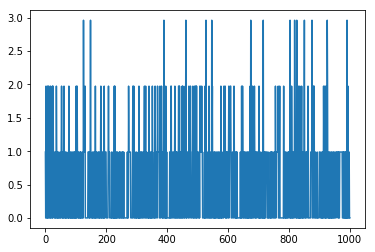

The mean is  0.5352671678676837
The MSE is  0.24875622687059268
The 95 percent confidence interval is between -0.462 and 1.533


In [16]:
if __name__ == "__main__":
    r = 0.05
    vol = 0.15
    S0 = 95
    iGBM = GBM(r,vol,S0)
    T = 0.25
    m = 50
    H = 85
    K = 96
    k = 1000
    n = 1000

    Price = np.zeros(n)
    for j in range(n):
        payoff = 0
        for i in range(k):
            W_t = iGBM._Wn(T,m)
            t = np.linspace(0,T,m+1)
            St = iGBM._explicit_sol_(t,W_t)

            if St[-1] > K and min(St) < H:
                payoff = payoff + 1000
        Price[j] = payoff / k*np.exp(-r * T)

    print('The final price is ',np.mean(Price))
    plt.plot(np.linspace(0,n,n),Price)
    plt.show()

    mean = np.mean(Price)
    print('The mean is ',mean)

    mse = np.mean((Price - np.mean(Price)**2))
    print('The MSE is ',mse)
    print('The 95 percent confidence interval is between %4.3f and %4.3f' %(mean - 2*np.sqrt(mse), mean + 2*np.sqrt(mse)))

### Answer for question 2
* Knock-in payoff is given as below

$$F(S) =exp(-rT) \cdot 1000\cdot I(S_T > K)\cdot I(min_{1 \leq k \leq m} S (t_k) < H) $$

* Crude Monte Carlo simulation can be sampled from the below normal random distribution f(x)

$$ S_t = S_0 * exp(L_n)  $$
$$ L_n = \sum_{i=1}^{m}X_i  $$
$$ X_i \backsim N((r-\frac{\sigma^2}{2})\delta t,\sigma^2 \delta t)  $$

* If Importance Sampling (IS) is adopted, the alternative normal random distribution g(x) and the likelihood ratio are as follows

$$ X_i \backsim N((r-\frac{\sigma^2}{2})\delta t-b,\sigma^2 \delta t)  $$
$$ \frac {f(x_1,x_2,...,x_m)}{g(x_1,x_2,...,x_m)} = exp(-\frac{1}{2}\sum_{k=1}^{m}{\frac{(x_k-\mu)}{\sigma \sqrt{\delta t}}}^2) \cdot exp(\frac{1}{2}\sum_{k=1}^{m}{\frac{(x_k-\mu+b)}{\sigma \sqrt{\delta t}}}^2)
= exp( \frac{b}{\sigma ^2 \delta t}\sum_{k=1}^{m}x_k-\frac{mb}{\sigma^2}(r-\frac{\sigma^2}{2})+\frac{mb^2}{2 \sigma^2 \delta t}     )                                                                            $$

* The payoff is as below (The sampling should follow the alternative pdf g(x))

$$ exp(-rT)\cdot \frac {f(x_1,x_2,...,x_m)}{g(x_1,x_2,...,x_m)} \cdot F^{g(x)}(S)$$

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats


In [18]:
r=0.05
vol=0.15
S0=95
T=0.25
m=50
H=85
K=96
k=1000
n=1000
dt=T/m

* equivalent mu and sig

In [19]:
b=math.log(S0/H)/m
c=math.log(K/S0)

mudt2=(r-0.5*vol**2)*dt-b
mudt1=(r-0.5*vol**2)*dt

In [20]:
sidt=vol*np.sqrt(dt)

NCrossed=np.zeros(k)

#Payoff=np.zeros(k)
Times=np.zeros(k)
StockVals=np.zeros(k)
ISRatio=np.zeros(k)

Ncrossed=0
TBreach=0
Price=np.zeros(n)

for counter in range(n):
    Payoff=np.zeros(k)
    for i in range(k):
        vetZ=np.random.normal(mudt2,sidt,m)
        ##vetZ2=np.hstack()
        vetZ2=np.hstack((math.log(S0),vetZ))
        LogPath=np.cumsum(vetZ2)
        St=np.exp(LogPath)


        jcross=0
        for j in range(len(St)):
            if St[j]<H:
                jcross=j
                break
            #print(jcross)
            #the path crosses the lower barrier
        if jcross>0:
                
           
            ISRatio[Ncrossed]=np.exp(m*b**2/2/vol**2/dt+b/vol**2/dt*np.sum(vetZ)-m*b/vol**2*(r-vol**2/2))
                
            if St[-1]>K:
                Payoff[Ncrossed]=ISRatio[Ncrossed]*1000*np.exp(-r*T)
                Ncrossed=Ncrossed+1
        
    Price[counter]=np.sum(Payoff)/k   
    #print(counter)    
print('The final payoff is: ',np.mean(Price))

The final payoff is:  0.48726553141757084


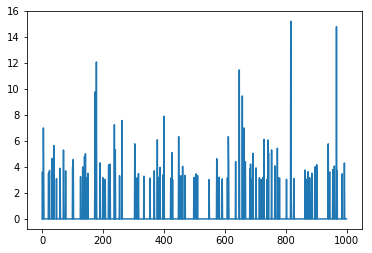

The mean is  0.48726553141757084
The standard is  0.49983780700335495
The 95 percent confidence interval is between -0.512 and 1.487


In [21]:
plt.plot(np.linspace(0,n,n),Price)
plt.show()
mean=np.mean(Price)
print('The mean is ',mean)
std=np.sqrt(np.mean((Price-np.mean(Price)**2)))
print('The standard is ',std)
print('The 95 percent confidence interval is between %4.3f and %4.3f' %(mean-2*std,mean+2*std)) 

### Answer for question 3

The optimal biased density function should have a similar shape of the original density function but with a thicker tail, in other words, the biased density function should have a revised drift value as well as an expanded standard deviation. 

In my selection of biased density function, I only assign a shifted dirft to increase the chance of crossing the barrier. I assume the logarithmic proportion log(S0/H) is distributed evenly along the m time steps. Although the chance of crossing the barier increases. The change of crossing the exercise price K at the maturity date has decreased. So my selection of biased density function is not the optimal.

* Revised drift value
$$ b=\frac{1}{m} log(\frac{S_0}{H}) $$
* Initial Density Function f(x)
$$ X_i \backsim N((r-\frac{\sigma^2}{2})\delta t,\sigma^2 \delta t)  $$
* Biased Density Function g(x)
$$ X_i \backsim N((r-\frac{\sigma^2}{2})\delta t-b,\sigma^2 \delta t)  $$

In [27]:
import numpy as np
from scipy.stats import norm
import scipy.stats as ss
import matplotlib.pyplot as plt
from pylab import plt

In [28]:
def bm_1d(T, m):
    dt = T/m
    dW = np.sqrt(dt)*norm.rvs(size = m)
    return dW.cumsum()

def abm_1d(T, m, b, sigma, x0):
    dt = T/m
    dW = np.sqrt(dt)*norm.rvs(size = m)
    dX = b*dt + sigma*dW
    X = dX.cumsum()
    return x0 + X

def gbm_1d(T, m, b, sigma, x0):
    L = abm_1d(T, m, b - 0.5*sigma**2, sigma, 0) #normalized log process
    return x0*np.exp(L)

In [29]:
r = .05; sigma = 0.15; s0 = 95
T = 0.25; H = 85; K = 96
k = 1000; n = 1000; m = 50
dt = T/m

In [30]:
val = np.zeros(k)
payoff = np.zeros(n)
for i in np.arange(k):
    for j in np.arange(n):
        S = gbm_1d(T, m, r, sigma, s0)
        payoff[j] = 1000*float(S[-1]>K)*float(S.min()<H)
    val[i] = payoff.mean()*np.exp(-r*T)

In [31]:
a = 0.05
Int_l = sample_mean - sample_variance/ np.sqrt(k) * ss.norm.cdf(a/2)
Int_r = sample_mean + sample_variance/ np.sqrt(k) * ss.norm.cdf(a/2)
b = - np.log(H/s0)
c = np.log(K/s0)
r_1 = 0.06
r_2 = 0.06
theta_1 = - (r_1 + r)/sigma
theta_2 =  (r_2 - r) /sigma

h = int(m/2)

In [32]:
r_list = np.linspace(0.03, 0.07, 5)

l = 5
val = np.zeros(k)
payoff = np.zeros(n)
sample_variance = np.zeros(l)
sample_mean = np.zeros(l)

for s in np.arange(l):
    for i in np.arange(k):
        for j in np.arange(n):
            dW = np.sqrt(dt)*norm.rvs(size = m)
            W_t = dW.cumsum()     
            dL1_t = (- r_list[s] - 0.5 * sigma**2) *dt + sigma * dW[0:h]   
            dL2_t = (r_list[s] - 0.5 *sigma**2)*dt + sigma* dW[h:(m+1)]       
            L = np.append(dL1_t , dL2_t).cumsum()     
            theta_1 = - (r_list[s] + r)/sigma
            theta_2 =  (r_list[s] - r) /sigma
            gamma1 = theta_1 * dL1_t.cumsum()[-1] + theta_2 * dL2_t.cumsum()[-1] - (theta_1**2 + theta_2**2)/T/4
            gamma = np.exp(gamma1)
            payoff[j] = 1000*float(L[-1]>c)*float(L.min()<-b) * gamma 
        val[i] = payoff.mean()*np.exp(-r*T)
    sample_mean[s] = val.mean()
    sample_variance[s] = val.var()

print(sample_mean)
print(sample_variance)

[0.52890069 0.50666428 0.56383651 0.56788723 0.5235034 ]
[0.35728172 0.35698573 0.39200925 0.3541247  0.3064223 ]


The MSE of the MC simulation change with the $r_1$ and $r_2$ we have seted, but the change of the option value is relatively smaller. So the $\hat{r_s}$ we choosed in the question 2 is not the optimal one. 